# Neuroevolution (GA) Multi-Seed Report (Best Model Selection)

This notebook loads the **best genome** from each training run (selected by the combined metric
`mean_reward - std_reward` during training) and runs evaluation and visualization.

No training is required — run lab009_v1_genome.ipynb first to generate the genome files.

Models are loaded from timestamped run folders: `models/ga/{timestamp}/best_genome.npy`

---

In [1]:
import os, sys, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import gymnasium as gym
import imageio.v2 as imageio
from IPython.display import Image, display

In [2]:
# Add src/ to path
SRC_DIR = os.path.join(os.path.dirname(os.path.abspath("__file__")), "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from src.evolution.neural_network import NeuralNetwork

In [3]:
# Configuration

SEED_LIST = [42, 123, 999]

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"

WIND_ENABLED = False

EVALUATION_EPISODES = 20

TRAJECTORY_EPISODES = 3

# Network architecture (must match training)
INPUT_SIZE = 8
HIDDEN1_SIZE = 10
HIDDEN2_SIZE = 10
OUTPUT_SIZE = 4

# Session prefix — must match the final genome filenames from training
# (e.g. lab009_ga_42.npy -> SESSION_PREFIX = "lab009")
SESSION_PREFIX = "lab009"

# LunarLander-v3 action labels
ACTION_LABELS = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]


def discover_best_genomes(session_prefix):
    """
    Scan models/ga/{timestamp}/ folders and return a dict:
        {seed: {"best": path_to_best_genome, "run_dir": path, "eval_log": path_or_None}}
    Only considers runs whose final genome filename starts with session_prefix.
    """
    models_root = os.path.join(NOTEBOOK_DIR, "../models", "ga")
    best_genomes = {}

    if not os.path.isdir(models_root):
        return best_genomes

    for run_folder in sorted(glob.glob(os.path.join(models_root, "????-??-??_??_??_??"))):
        best_genome_path = os.path.join(run_folder, "best_genome.npy")
        if not os.path.isfile(best_genome_path):
            continue

        # Find the final genome file to extract session and seed
        for f in os.listdir(run_folder):
            if f.startswith(session_prefix) and f.endswith(".npy") and f != "best_genome.npy":
                seed_str = f.replace(".npy", "").split("_")[-1]
                if seed_str.isdigit():
                    seed_int = int(seed_str)
                    if seed_int in SEED_LIST:
                        eval_log_path = os.path.join(run_folder, "eval_log", "evaluations.npz")
                        fitness_path = None
                        for ff in os.listdir(run_folder):
                            if ff.startswith("fitness_history") and ff.endswith(".npz"):
                                fitness_path = os.path.join(run_folder, ff)
                                break
                        best_genomes[seed_int] = {
                            "best": best_genome_path,
                            "run_dir": run_folder,
                            "eval_log": eval_log_path if os.path.isfile(eval_log_path) else None,
                            "fitness_history": fitness_path,
                        }
                break

    return best_genomes


# Discover best genomes for this session
best_genome_paths = discover_best_genomes(SESSION_PREFIX)

print(f"Session: {SESSION_PREFIX}")
print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print()
print("Discovered best genomes:")
for seed in SEED_LIST:
    info = best_genome_paths.get(seed)
    if info:
        print(f"  Seed {seed}: {info['best']}")
        print(f"    Eval log: {'Yes' if info['eval_log'] else 'No'}")
        print(f"    Fitness history: {'Yes' if info['fitness_history'] else 'No'}")
    else:
        print(f"  Seed {seed}: NOT FOUND")

Session: lab009
Seeds: [42, 123, 999]
Wind enabled: False
Evaluation episodes per seed: 20

Discovered best genomes:
  Seed 42: /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_11_43/best_genome.npy
    Eval log: Yes
    Fitness history: Yes
  Seed 123: /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_30_31/best_genome.npy
    Eval log: Yes
    Fitness history: Yes
  Seed 999: /home/logus/env/iscte/taap_p2/genetic/../models/ga/2026-02-21_06_54_10/best_genome.npy
    Eval log: Yes
    Fitness history: Yes


In [4]:
# Helper functions

def evaluate_genome_deterministic(genome, n_episodes, seed=None):
    """
    Evaluate a genome deterministically over n_episodes.
    No early termination. Returns list of per-episode rewards.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    rewards = []

    for ep in range(n_episodes):
        ep_seed = seed + ep if seed is not None else None
        obs, _ = env.reset(seed=ep_seed)
        total_reward = 0.0
        done = False

        while not done:
            output = nn.forward(obs)
            action = np.argmax(output)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += float(reward)

        rewards.append(total_reward)

    env.close()
    return rewards


def record_genome_gif(genome, seed, output_path):
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
    obs, _ = env.reset(seed=seed)
    frames = []
    done = False

    while not done:
        frames.append(env.render())
        output = nn.forward(obs)
        action = np.argmax(output)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    imageio.mimsave(output_path, frames, fps=30, loop=0)
    return output_path

In [5]:
# Load best genomes and evaluate

loaded_genomes = {}       # {seed: np.array}
evaluation_results = {}   # {seed: np.array}

for seed in SEED_LIST:
    info = best_genome_paths.get(seed)
    if info is None:
        print(f"SKIPPING seed {seed} - best genome not found")
        continue

    print(f"Loading and evaluating GA seed {seed} (best genome)...")

    genome = np.load(info["best"])
    loaded_genomes[seed] = genome

    rewards = evaluate_genome_deterministic(genome, EVALUATION_EPISODES, seed=seed)
    evaluation_results[seed] = np.array(rewards)

    mean_r = np.mean(rewards)
    std_r = np.std(rewards)
    success = np.sum(np.array(rewards) >= 200) / len(rewards) * 100
    print(f"  Reward: {mean_r:.2f} +/- {std_r:.2f} | Success: {success:.0f}%")

print(f"\nEvaluation complete.")

Loading and evaluating GA seed 42 (best genome)...
  Reward: 290.64 +/- 20.52 | Success: 100%
Loading and evaluating GA seed 123 (best genome)...
  Reward: 301.73 +/- 10.95 | Success: 100%
Loading and evaluating GA seed 999 (best genome)...
  Reward: 287.12 +/- 17.77 | Success: 100%

Evaluation complete.


---

## Training History

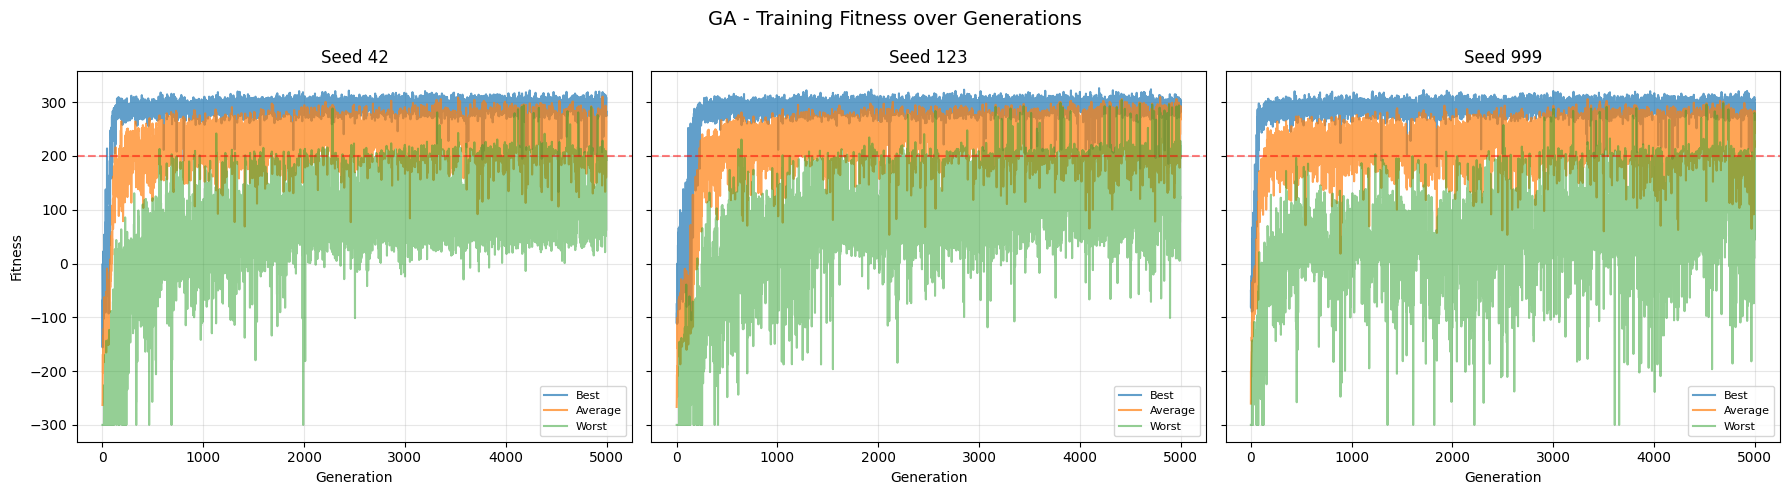

In [6]:
# Training Fitness Curves (loaded from saved history)

has_history = any(best_genome_paths.get(s, {}).get("fitness_history") for s in SEED_LIST)

if has_history:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        info = best_genome_paths.get(seed)
        if info and info["fitness_history"]:
            data = np.load(info["fitness_history"])
            ax.plot(data["best"], alpha=0.7, label="Best")
            ax.plot(data["avg"], alpha=0.7, label="Average")
            ax.plot(data["worst"], alpha=0.5, label="Worst")
            ax.axhline(y=200, color='red', linestyle='--', alpha=0.5)
            ax.legend(fontsize=8)
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Generation")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Fitness")
    fig.suptitle("GA - Training Fitness over Generations", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No fitness history files found.")

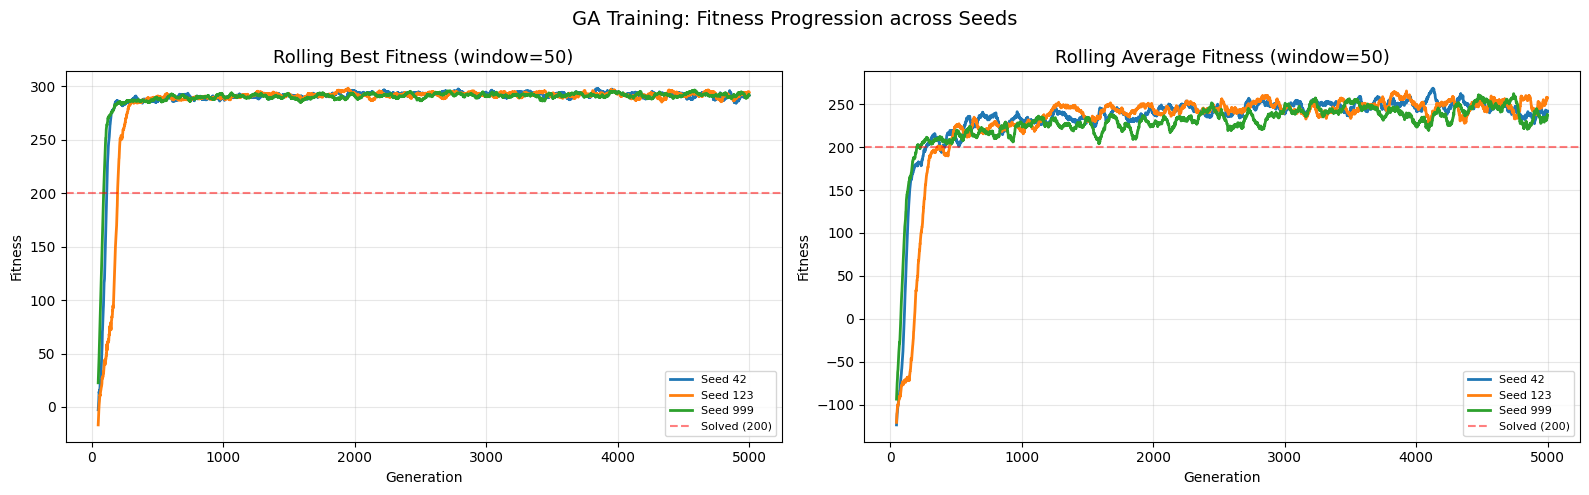

In [7]:
# Training: Rolling Best and Average Fitness (all seeds overlaid)

if has_history:
    seed_colors = list(plt.colormaps["tab10"](range(10)))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    for i, seed in enumerate(SEED_LIST):
        info = best_genome_paths.get(seed)
        if info and info["fitness_history"]:
            data = np.load(info["fitness_history"])
            rolling_best = pd.Series(data["best"]).rolling(50).mean()
            rolling_avg = pd.Series(data["avg"]).rolling(50).mean()
            ax1.plot(rolling_best, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")
            ax2.plot(rolling_avg, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

    ax1.axhline(y=200, color='red', linestyle='--', alpha=0.5, label='Solved (200)')
    ax1.set_title("Rolling Best Fitness (window=50)", fontsize=13)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    ax2.axhline(y=200, color='red', linestyle='--', alpha=0.5, label='Solved (200)')
    ax2.set_title("Rolling Average Fitness (window=50)", fontsize=13)
    ax2.set_xlabel("Generation")
    ax2.set_ylabel("Fitness")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle("GA Training: Fitness Progression across Seeds", fontsize=14)
    plt.tight_layout()
    plt.show()

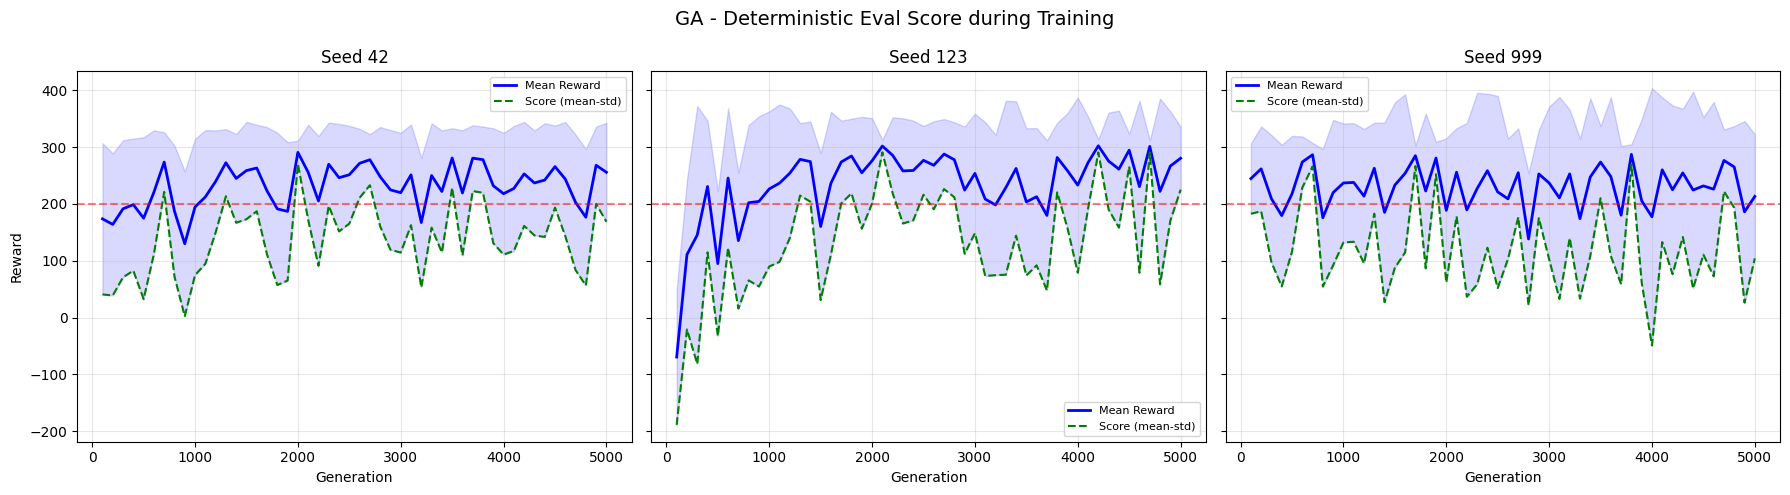

In [8]:
# Eval Score Progression during Training (from eval_log)

has_eval_log = any(best_genome_paths.get(s, {}).get("eval_log") for s in SEED_LIST)

if has_eval_log:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        info = best_genome_paths.get(seed)
        if info and info["eval_log"]:
            data = np.load(info["eval_log"])
            gens = data["generations"]
            means = data["means"]
            stds = data["stds"]
            scores = data["scores"]

            ax.plot(gens, means, color='blue', linewidth=2, label='Mean Reward')
            ax.fill_between(gens, means - stds, means + stds, color='blue', alpha=0.15)
            ax.plot(gens, scores, color='green', linewidth=1.5, linestyle='--', label='Score (mean-std)')
            ax.axhline(y=200, color='red', linestyle='--', alpha=0.5)
            ax.legend(fontsize=8)

        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Generation")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Reward")
    fig.suptitle("GA - Deterministic Eval Score during Training", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No eval log files found.")

---

## Evaluation Results

In [9]:
# Evaluation Summary Table

rows = []
for seed in SEED_LIST:
    r = evaluation_results[seed]
    rows.append({
        "Seed": seed,
        "Mean Reward": f"{np.mean(r):.2f}",
        "Std Dev": f"{np.std(r):.2f}",
        "Min Reward": f"{np.min(r):.2f}",
        "Max Reward": f"{np.max(r):.2f}",
        "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
    })

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])
rows.append({
    "Seed": "Overall",
    "Mean Reward": f"{np.mean(all_r):.2f}",
    "Std Dev": f"{np.std(all_r):.2f}",
    "Min Reward": f"{np.min(all_r):.2f}",
    "Max Reward": f"{np.max(all_r):.2f}",
    "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
})

print(f"*** GA MULTI-SEED EVALUATION SUMMARY ***")
print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
print(pd.DataFrame(rows).to_string(index=False))

*** GA MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      290.64   20.52     258.55     321.98       100.0%
    123      301.73   10.95     284.02     319.78       100.0%
    999      287.12   17.77     254.22     320.95       100.0%
Overall      293.16   18.01     254.22     321.98       100.0%


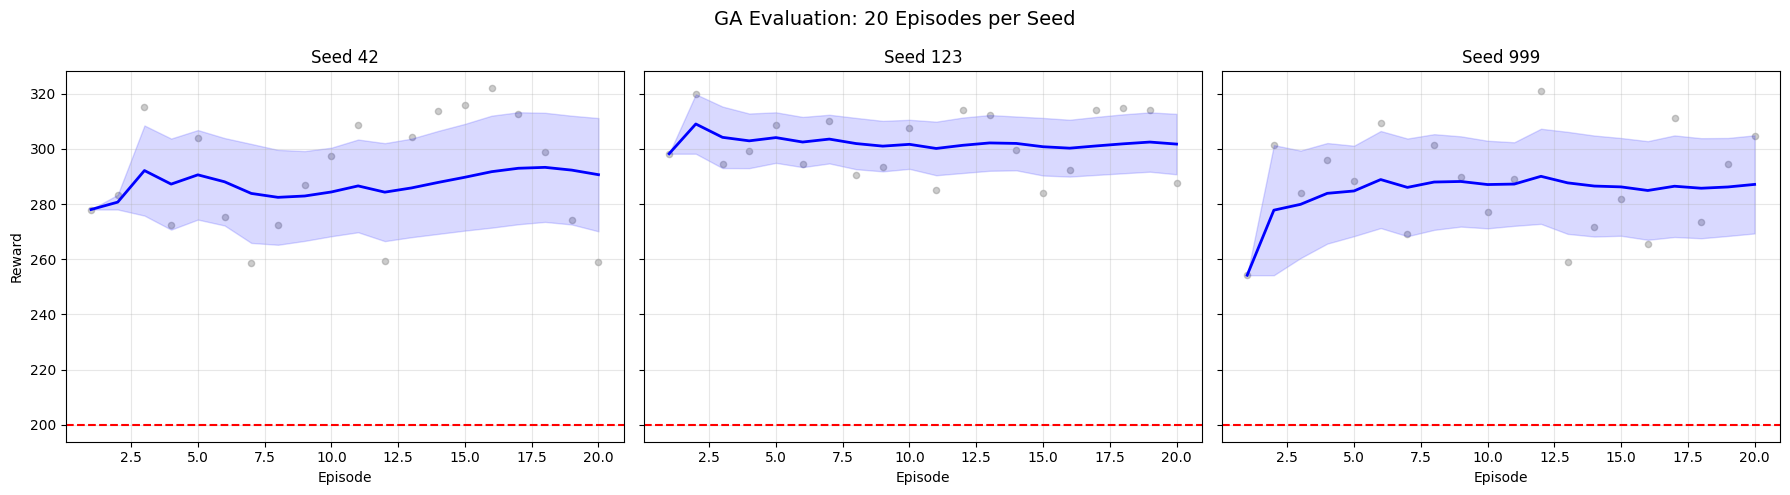

In [10]:
# Evaluation Convergence Plots (per seed)

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    rewards = evaluation_results[seed]
    episodes = np.arange(1, len(rewards) + 1)
    running_mean = np.cumsum(rewards) / episodes
    running_std = np.array([np.std(rewards[:i]) for i in episodes])

    ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20, label='Episode Reward')
    ax.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
    ax.fill_between(episodes, running_mean - running_std, running_mean + running_std,
                    color='blue', alpha=0.15)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Episode")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"GA Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
plt.tight_layout()
plt.show()

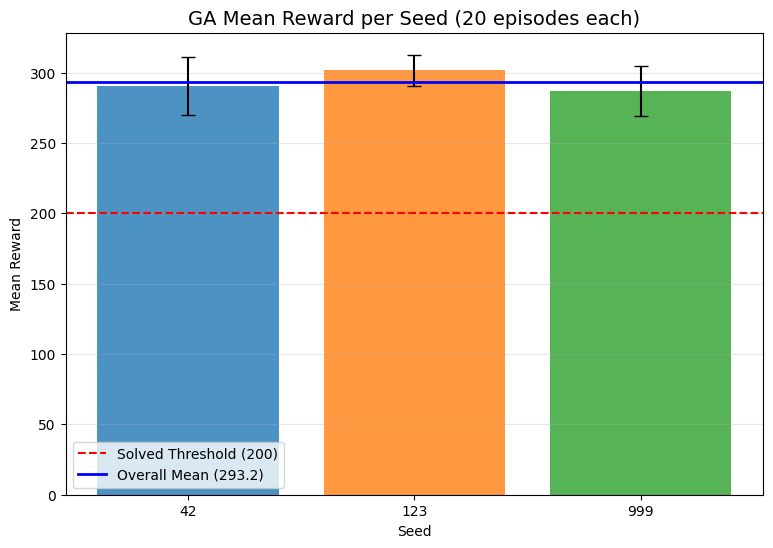

In [11]:
# Evaluation Bar Chart (mean reward per seed with error bars)

seed_colors = list(plt.colormaps["tab10"](range(10)))

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])
means = [np.mean(evaluation_results[s]) for s in SEED_LIST]
stds_vals = [np.std(evaluation_results[s]) for s in SEED_LIST]
labels = [str(s) for s in SEED_LIST]

plt.figure(figsize=(max(8, 3 * len(SEED_LIST)), 6))
plt.bar(labels, means, yerr=stds_vals, capsize=5, color=seed_colors[:len(SEED_LIST)], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.axhline(y=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
            label=f'Overall Mean ({np.mean(all_r):.1f})')

plt.title(f"GA Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

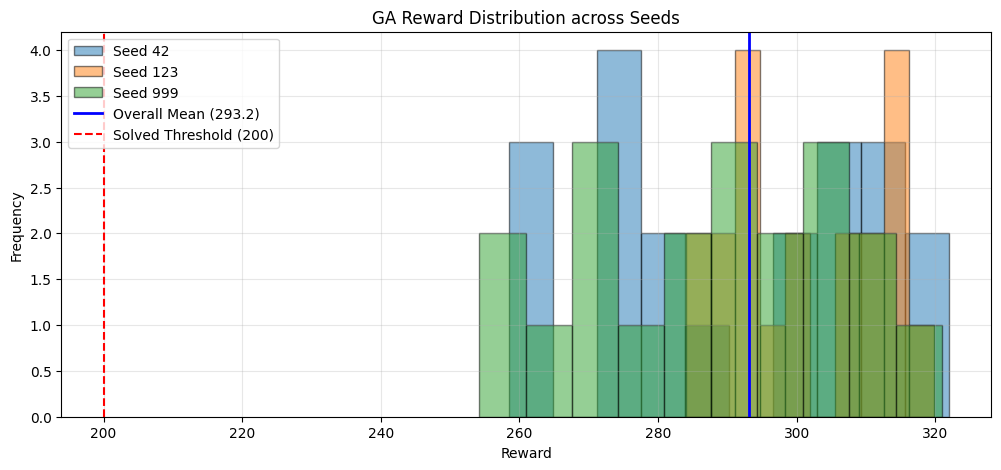

In [12]:
# Reward Distribution Histograms (overlaid per seed)

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])

plt.figure(figsize=(12, 5))
for i, seed in enumerate(SEED_LIST):
    plt.hist(evaluation_results[seed], bins=10, alpha=0.5,
             color=seed_colors[i], edgecolor='black', label=f"Seed {seed}")

plt.axvline(x=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
            label=f'Overall Mean ({np.mean(all_r):.1f})')
plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title('GA Reward Distribution across Seeds')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_5113/360661104.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[str(s) for s in SEED_LIST], patch_artist=True)


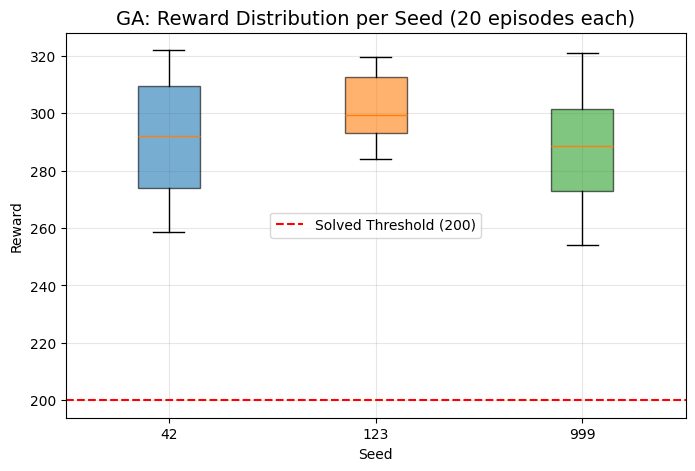

In [ ]:
# Box Plot per Seed

fig, ax = plt.subplots(figsize=(8, 5))

data = [evaluation_results[seed] for seed in SEED_LIST]
bp = ax.boxplot(data, tick_labels=[str(s) for s in SEED_LIST], patch_artist=True)
for patch, color in zip(bp['boxes'], seed_colors[:len(SEED_LIST)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
ax.set_title(f"GA: Reward Distribution per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
ax.set_xlabel("Seed")
ax.set_ylabel("Reward")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

---

## Baseline Comparison

In [14]:
# Random Agent Baseline Evaluation

random_results = {}

for seed in SEED_LIST:
    print(f"Running random agent with seed {seed}...")
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    env.action_space.seed(seed)
    episode_rewards = []

    for ep in range(EVALUATION_EPISODES):
        obs, info = env.reset(seed=seed + ep)
        total_reward = 0.0
        done = False

        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += float(reward)
            done = terminated or truncated

        episode_rewards.append(total_reward)

    random_results[seed] = np.array(episode_rewards)
    env.close()

print("Random baseline evaluation complete.")

Running random agent with seed 42...
Running random agent with seed 123...
Running random agent with seed 999...
Random baseline evaluation complete.


*** BASELINE COMPARISON ***
      Agent Mean Reward Std Dev     Min    Max Success Rate
     Random     -205.65  109.48 -420.28  15.45         0.0%
         GA      293.16   18.01  254.22 321.98       100.0%
Human (ref)    ~200-300       -       -      -        ~100%



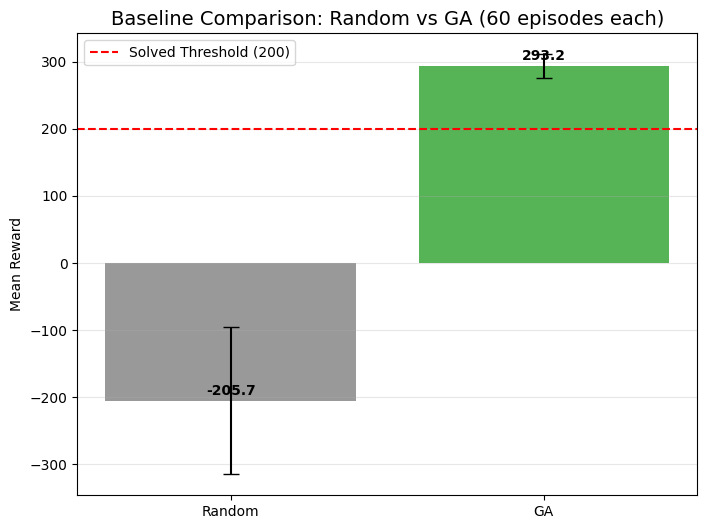

In [15]:
# Baseline Comparison: Table + Chart

all_ga = np.concatenate([evaluation_results[s] for s in SEED_LIST])
all_random = np.concatenate([random_results[s] for s in SEED_LIST])

rows = [
    {
        "Agent": "Random",
        "Mean Reward": f"{np.mean(all_random):.2f}",
        "Std Dev": f"{np.std(all_random):.2f}",
        "Min": f"{np.min(all_random):.2f}",
        "Max": f"{np.max(all_random):.2f}",
        "Success Rate": f"{(all_random >= 200).sum() / len(all_random) * 100:.1f}%"
    },
    {
        "Agent": "GA",
        "Mean Reward": f"{np.mean(all_ga):.2f}",
        "Std Dev": f"{np.std(all_ga):.2f}",
        "Min": f"{np.min(all_ga):.2f}",
        "Max": f"{np.max(all_ga):.2f}",
        "Success Rate": f"{(all_ga >= 200).sum() / len(all_ga) * 100:.1f}%"
    },
    {
        "Agent": "Human (ref)",
        "Mean Reward": "~200-300",
        "Std Dev": "-",
        "Min": "-",
        "Max": "-",
        "Success Rate": "~100%"
    }
]

print("*** BASELINE COMPARISON ***")
print(pd.DataFrame(rows).to_string(index=False))
print()

# Bar chart
agent_labels = ["Random", "GA"]
agent_means = [np.mean(all_random), np.mean(all_ga)]
agent_stds = [np.std(all_random), np.std(all_ga)]
bar_colors = ["gray", "tab:green"]

plt.figure(figsize=(8, 6))
bars = plt.bar(agent_labels, agent_means, yerr=agent_stds, capsize=6,
               color=bar_colors, alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, agent_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Baseline Comparison: Random vs GA ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

---

## Statistical Significance

In [ ]:
# Statistical Significance: GA vs Random (Mann-Whitney U + Chi-squared)

# --- Reward comparison (Mann-Whitney U) ---
mwu_result = stats.mannwhitneyu(all_ga, all_random, alternative='two-sided')
stat_reward = float(mwu_result.statistic)
p_reward = float(mwu_result.pvalue)

# --- Success rate comparison (Chi-squared) ---
ga_successes = int((all_ga >= 200).sum())
random_successes = int((all_random >= 200).sum())
ga_total = len(all_ga)
random_total = len(all_random)

contingency = np.array([
    [ga_successes, ga_total - ga_successes],
    [random_successes, random_total - random_successes]
])

if np.all(contingency.sum(axis=0) > 0) and np.all(contingency.sum(axis=1) > 0):
    result = stats.chi2_contingency(contingency)
    chi2 = float(result.statistic)  # type: ignore[attr-defined]
    p_success = float(result.pvalue)  # type: ignore[attr-defined]
    chi2_valid = True
else:
    chi2, p_success = 0.0, 1.0
    chi2_valid = False

# --- Results table ---
chi2_note = "" if chi2_valid else " (skipped: zero row/col)"
rows = [
    {
        "Metric": "Mean Reward",
        "GA Value": f"{np.mean(all_ga):.2f}",
        "Random Value": f"{np.mean(all_random):.2f}",
        "Test": "Mann-Whitney U",
        "Statistic": f"{stat_reward:.1f}",
        "p-value": f"{p_reward:.4f}",
        "Significant (p<0.05)": "Yes" if p_reward < 0.05 else "No"
    },
    {
        "Metric": "Success Rate (>=200)",
        "GA Value": f"{ga_successes/ga_total*100:.1f}%",
        "Random Value": f"{random_successes/random_total*100:.1f}%",
        "Test": f"Chi-squared{chi2_note}",
        "Statistic": f"{chi2:.2f}",
        "p-value": f"{p_success:.4f}",
        "Significant (p<0.05)": "Yes" if (chi2_valid and p_success < 0.05) else "No"
    },
]

print("*** STATISTICAL SIGNIFICANCE TESTS: GA vs Random ***")
print(f"Sample size per agent: {ga_total} episodes ({EVALUATION_EPISODES} episodes x {len(SEED_LIST)} seeds)")
print()
print(pd.DataFrame(rows).to_string(index=False))
print()
if p_reward < 0.05:
    print(f"The reward difference between GA and Random is statistically significant (p={p_reward:.4f}).")
else:
    print(f"No statistically significant reward difference between GA and Random (p={p_reward:.4f}).")

*** STATISTICAL SIGNIFICANCE TESTS: GA vs Random ***
Sample size per agent: 60 episodes (20 episodes x 3 seeds)

              Metric GA Value Random Value           Test Statistic p-value Significant (p<0.05)
         Mean Reward   293.16      -205.65 Mann-Whitney U    3600.0  0.0000                  Yes
Success Rate (>=200)   100.0%         0.0%    Chi-squared    116.03  0.0000                  Yes

The reward difference between GA and Random is statistically significant (p=0.0000).


---

## Agent Behavior Analysis

In [17]:
# Collect per-step data: actions and trajectories

action_counts = np.zeros(len(ACTION_LABELS), dtype=int)
trajectory_data = []  # list of (x_positions, y_positions)

for seed in SEED_LIST:
    genome = loaded_genomes[seed]
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)

    for ep in range(EVALUATION_EPISODES):
        obs, info = env.reset(seed=seed + ep)
        done = False
        x_pos, y_pos = [obs[0]], [obs[1]]

        while not done:
            output = nn.forward(obs)
            action = int(np.argmax(output))
            action_counts[action] += 1

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            x_pos.append(obs[0])
            y_pos.append(obs[1])

        # Keep trajectory for the first TRAJECTORY_EPISODES episodes of the first seed
        if seed == SEED_LIST[0] and ep < TRAJECTORY_EPISODES:
            trajectory_data.append((np.array(x_pos), np.array(y_pos)))

    env.close()

total_actions = action_counts.sum()
print(f"GA: {total_actions:,} total actions collected across {EVALUATION_EPISODES * len(SEED_LIST)} episodes")
print("\nBehavior data collection complete.")

GA: 11,461 total actions collected across 60 episodes

Behavior data collection complete.


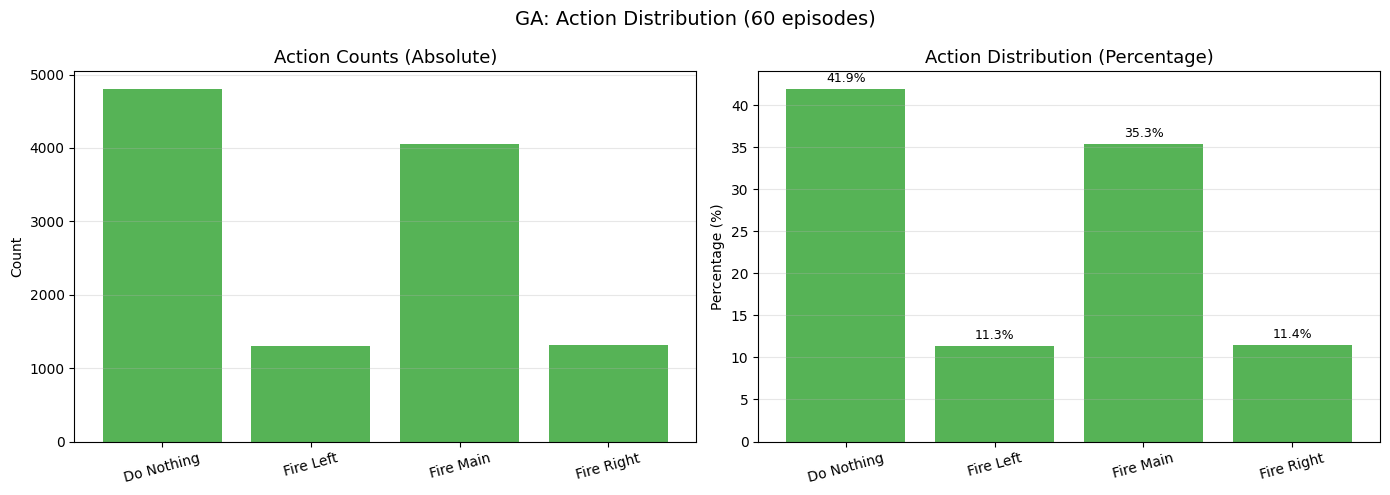

In [18]:
# Action Distribution

n_actions = len(ACTION_LABELS)
x = np.arange(n_actions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
ax1.bar(x, action_counts, color='tab:green', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(ACTION_LABELS, rotation=15)
ax1.set_title("Action Counts (Absolute)", fontsize=13)
ax1.set_ylabel("Count")
ax1.grid(True, alpha=0.3, axis='y')

# Percentage distribution
pcts = action_counts / action_counts.sum() * 100
bars = ax2.bar(x, pcts, color='tab:green', alpha=0.8)
for bar, pct in zip(bars, pcts):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_xticks(x)
ax2.set_xticklabels(ACTION_LABELS, rotation=15)
ax2.set_title("Action Distribution (Percentage)", fontsize=13)
ax2.set_ylabel("Percentage (%)")
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle(f"GA: Action Distribution ({EVALUATION_EPISODES * len(SEED_LIST)} episodes)", fontsize=14)
plt.tight_layout()
plt.show()

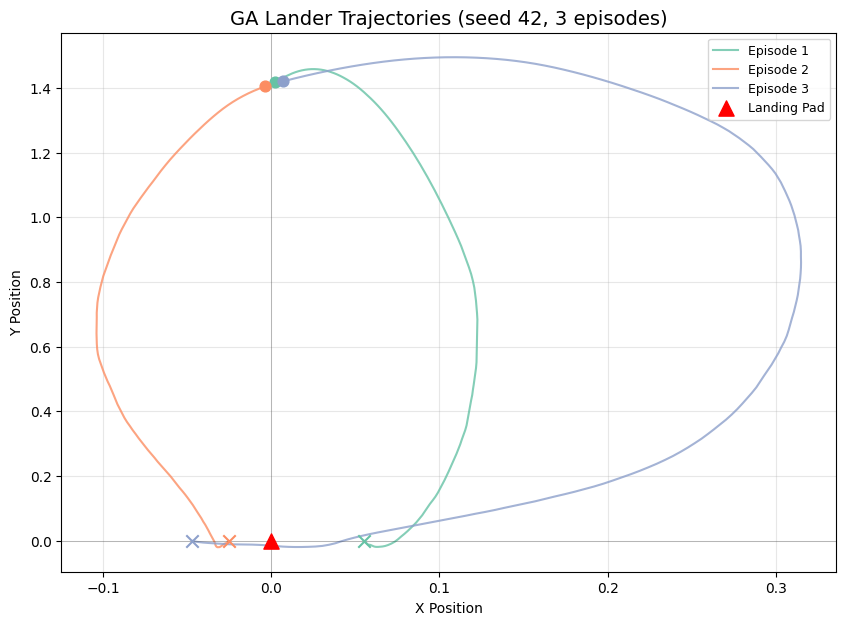

In [19]:
# Trajectory Plots: x-y paths of the lander

traj_colors = list(plt.colormaps["Set2"](range(8)))

fig, ax = plt.subplots(figsize=(10, 7))

for i, (x_pos, y_pos) in enumerate(trajectory_data):
    ax.plot(x_pos, y_pos, color=traj_colors[i], linewidth=1.5, alpha=0.8,
            label=f"Episode {i+1}")
    ax.scatter(x_pos[0], y_pos[0], color=traj_colors[i], marker='o', s=60, zorder=5)
    ax.scatter(x_pos[-1], y_pos[-1], color=traj_colors[i], marker='x', s=80, zorder=5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.scatter(0, 0, color='red', marker='^', s=120, zorder=10, label='Landing Pad')

ax.set_title(f"GA Lander Trajectories (seed {SEED_LIST[0]}, {TRAJECTORY_EPISODES} episodes)", fontsize=14)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

---

## GIF Visualizations

Generating GIF for GA seed 42 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed42.gif


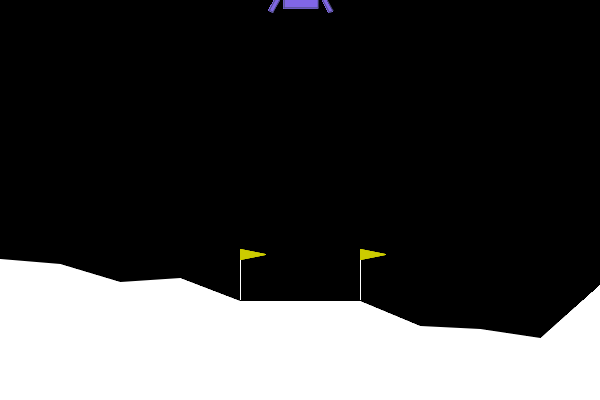

Generating GIF for GA seed 123 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed123.gif


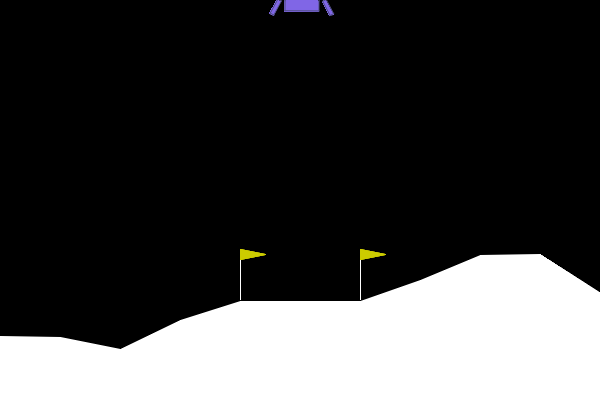

Generating GIF for GA seed 999 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/genetic/outputs_ga/ga_seed999.gif


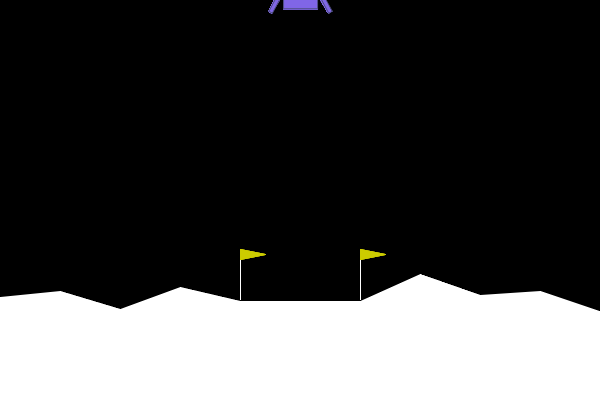

In [20]:
# GIF Visualizations (one per seed, best genome)

output_dir = os.path.join(NOTEBOOK_DIR, "outputs_ga")
os.makedirs(output_dir, exist_ok=True)

for seed in SEED_LIST:
    if seed not in loaded_genomes:
        print(f"SKIPPING GIF for seed {seed} - genome not loaded")
        continue

    print(f"Generating GIF for GA seed {seed} (best genome)...")

    gif_path = os.path.join(output_dir, f"ga_seed{seed}.gif")
    record_genome_gif(loaded_genomes[seed], seed, gif_path)

    print(f"  Saved: {gif_path}")
    display(Image(filename=gif_path))

---

## Appendix: Experimental Setup

### Environment Details

| Property | Value |
|---|---|
| Environment | `LunarLander-v3` (Gymnasium) |
| Observation Space | `Box(8,)` — continuous 8-dimensional vector |
| Action Space | `Discrete(4)` — do nothing, fire left, fire main, fire right |
| Solved Threshold | Mean reward >= 200 over 100 consecutive episodes |
| Wind | Disabled (`enable_wind=False`) |

**Observation vector:** `[x, y, vx, vy, angle, angular_velocity, left_leg_contact, right_leg_contact]`

**Reward structure:**
- Moving toward the landing pad: positive
- Moving away: negative
- Crash: -100
- Successful landing: +100
- Each leg ground contact: +10
- Firing main engine: -0.3 per frame
- Firing side engine: -0.03 per frame

**Termination rules:**
- **Terminated (success):** The lander comes to rest on the ground with both legs in contact, near-zero velocity
- **Terminated (crash):** The lander body contacts the ground, or the lander moves outside the viewport boundaries
- **Truncated (timeout):** The episode exceeds 1000 timesteps without termination

In [21]:
# Environment inspection

env_tmp = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
print(f"Environment: {GYMNASIUM_MODEL}")
print(f"Observation space: {env_tmp.observation_space}")
print(f"Action space: {env_tmp.action_space}")
print(f"Wind enabled: {WIND_ENABLED}")

obs, info = env_tmp.reset(seed=42)
print(f"\nSample observation: {obs}")
print(f"Observation labels: [x, y, vx, vy, angle, angular_vel, left_leg, right_leg]")
env_tmp.close()

Environment: LunarLander-v3
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Wind enabled: False

Sample observation: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
Observation labels: [x, y, vx, vy, angle, angular_vel, left_leg, right_leg]


In [22]:
# System and library versions

print(f"Python: {sys.version.split()[0]}")
print(f"Gymnasium: {gym.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Network: {INPUT_SIZE} -> {HIDDEN1_SIZE} -> {HIDDEN2_SIZE} -> {OUTPUT_SIZE}")
print(f"Activation: tanh (hidden), linear (output)")

Python: 3.12.3
Gymnasium: 1.2.3
NumPy: 2.4.2
Network: 8 -> 10 -> 10 -> 4
Activation: tanh (hidden), linear (output)


---